In [1]:
#importing necessary libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_MpHjUjU.csv') # Loading the dataset 
train[:10] #Checking first 10 rows of it

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
7,2017-02-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
8,2017-03-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,350000,1
9,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1


We see that there are multiple rows for the same employee with different Total Business Values hence we will group the data on the basis of Emp_ID and add up the Total Business Value to get single record for Each employee.

In [3]:
train.drop_duplicates(inplace = True)  #Dropping duplicates
print(train.shape) #Checking the shape after removing duplicates

(19104, 13)


In [4]:
train.columns # to check the columns to use in grouping and making col with it.

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

**Data Cleaning and Feature Engineering**

In [7]:
#getting the employee id's of the those who have left the organisation

attrition = train[['Emp_ID','LastWorkingDate','Dateofjoining']].dropna() 
attrition.sort_index(inplace=True)
attrition['Dateofjoining'] = pd.to_datetime(attrition['Dateofjoining'])
attrition['LastWorkingDate'] = pd.to_datetime(attrition['LastWorkingDate'], errors = 'ignore')
attrition['Tenurity'] = attrition['LastWorkingDate'] - attrition['Dateofjoining']
attrition['Tenurity'] = attrition['Tenurity'].apply(lambda x: str(x))
attrition.head(4)

,Emp_ID,LastWorkingDate,Dateofjoining,Tenurity
2,1,2016-03-11,2015-12-24,78 days 00:00:00
9,4,2017-04-27,2016-12-07,141 days 00:00:00
12,5,2016-03-07,2016-01-09,58 days 00:00:00
20,8,2017-11-15,2017-09-19,57 days 00:00:00


**Data for the employees who have left are separated**

**New Feature tenurity is derived from existing columns of LastWorkingDate and DateofJoining for them**

In [8]:
#Creating a new dataframe and grouping them together to get single row of data for each employee

df = train.groupby(['Emp_ID'], sort=False, as_index=False).agg(lambda x: np.unique(x).sum()) 
df.sort_index(inplace=True)

df.shape #Checking the shape of dataframe

(2381, 12)

In [9]:
#Merging both the extracted dataset together

df2 = pd.merge(df, attrition, on='Emp_ID', how='left')
df2.shape

(2381, 15)

In [10]:
df2['Attrition'] = pd.Series((df.Emp_ID.isin(attrition.Emp_ID)))
df2.shape
#Creating a new column named attrition depending upon whether they have left.

(2381, 16)

In [11]:
#Replacing the values of Attrition column True as 1(Left the origanisation), False as 0(didn't left yet)

df2['Attrition'].replace({True:[1],False:[0]}, regex = True, inplace = True)
df2.head(2)

,Emp_ID,MMM-YY,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,LastWorkingDate,Dateofjoining_y,Tenurity,Attrition
0,1,2016-01-012016-02-012016-03-01,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,2016-03-11,2015-12-24,78 days 00:00:00,1
1,2,2017-11-012017-12-01,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,NaT,NaT,NaN,0


In [12]:
# Dropping MMM-YY column from the dataset
df2.drop(['MMM-YY','Dateofjoining_y','LastWorkingDate'], axis =1, inplace = True)
df2.head(2)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,NaN,0


In [13]:
#Converting datatype of Dateofjoining_x to derive tenurity of remaining emloyees taking present day as 2017-12-31.

df2['Dateofjoining_x'] = pd.to_datetime(df2['Dateofjoining_x'])

#Filling up nan values of Tenurity for the remaining employess
from datetime import datetime
a_date = datetime.strptime('2017/12/31', "%Y/%m/%d") #Choosing the last working day of the quarter 
df2['Tenurity'].fillna(a_date - df2['Dateofjoining_x'], inplace = True)
df2.head(10)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,55 days 00:00:00,0
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,350000,1,141 days 00:00:00,1
3,5,29,Male,C9,College,46368,2016-01-09,1,1,120360,1,58 days 00:00:00,1
4,6,31,Female,C11,Bachelor,78728,2017-07-31,3,3,1265000,3,153 days 00:00:00,0
5,8,34,Male,C2,College,70656,2017-09-19,3,3,0,1,57 days 00:00:00,1
6,11,28,Female,C19,Master,42172,2017-12-07,1,1,0,1,24 days 00:00:00,0
7,12,35,Male,C23,Master,28116,2016-06-29,1,1,2607180,5,175 days 00:00:00,1
8,13,90,Male,C19,Master,119227,2012-05-28,1,4,9563040,3,2007 days 00:00:00,1
9,14,39,Female,C26,College,19734,2017-10-16,3,3,0,1,76 days 00:00:00,0


In [14]:
# Creating new feature Promotion based on existing feature of Designation and joining Designation
df2['Promoted'] =  df2['Designation'] - df2['Joining Designation']
df2.head(4)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1,0
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,55 days 00:00:00,0,0
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,350000,1,141 days 00:00:00,1,0
3,5,29,Male,C9,College,46368,2016-01-09,1,1,120360,1,58 days 00:00:00,1,0


In [15]:
#Separating day, month and year and making new features for that.
df2['Joining Day'] = df2['Dateofjoining_x'].dt.day
df2['Joining Month'] = df2['Dateofjoining_x'].dt.month
df2['Joining Year'] = df2['Dateofjoining_x'].dt.year

#Removing the existing DateofJoining column from the dataset as new features already created from it.
df2.drop(['Dateofjoining_x'], axis = 1, inplace = True)
df2.head()

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
0,1,28,Male,C23,Master,57387,1,1,1715580,2,78 days 00:00:00,1,0,24,12,2015
1,2,31,Male,C7,Master,67016,2,2,0,1,55 days 00:00:00,0,0,6,11,2017
2,4,43,Male,C13,Master,65603,2,2,350000,1,141 days 00:00:00,1,0,7,12,2016
3,5,29,Male,C9,College,46368,1,1,120360,1,58 days 00:00:00,1,0,9,1,2016
4,6,31,Female,C11,Bachelor,78728,3,3,1265000,3,153 days 00:00:00,0,0,31,7,2017


**We Created new column based on existing column of Joining Designation and Current Designation**

In [17]:
# Changed the datatype of Tenurity and removed unwanted string values from each of the value.

df2['Tenurity'] =  df2['Tenurity'].apply(lambda x: str(x).split(' ')[0])

df2['Tenurity'] = df2['Tenurity'].astype(int) #for changing the datatype.

**Data Visualization**

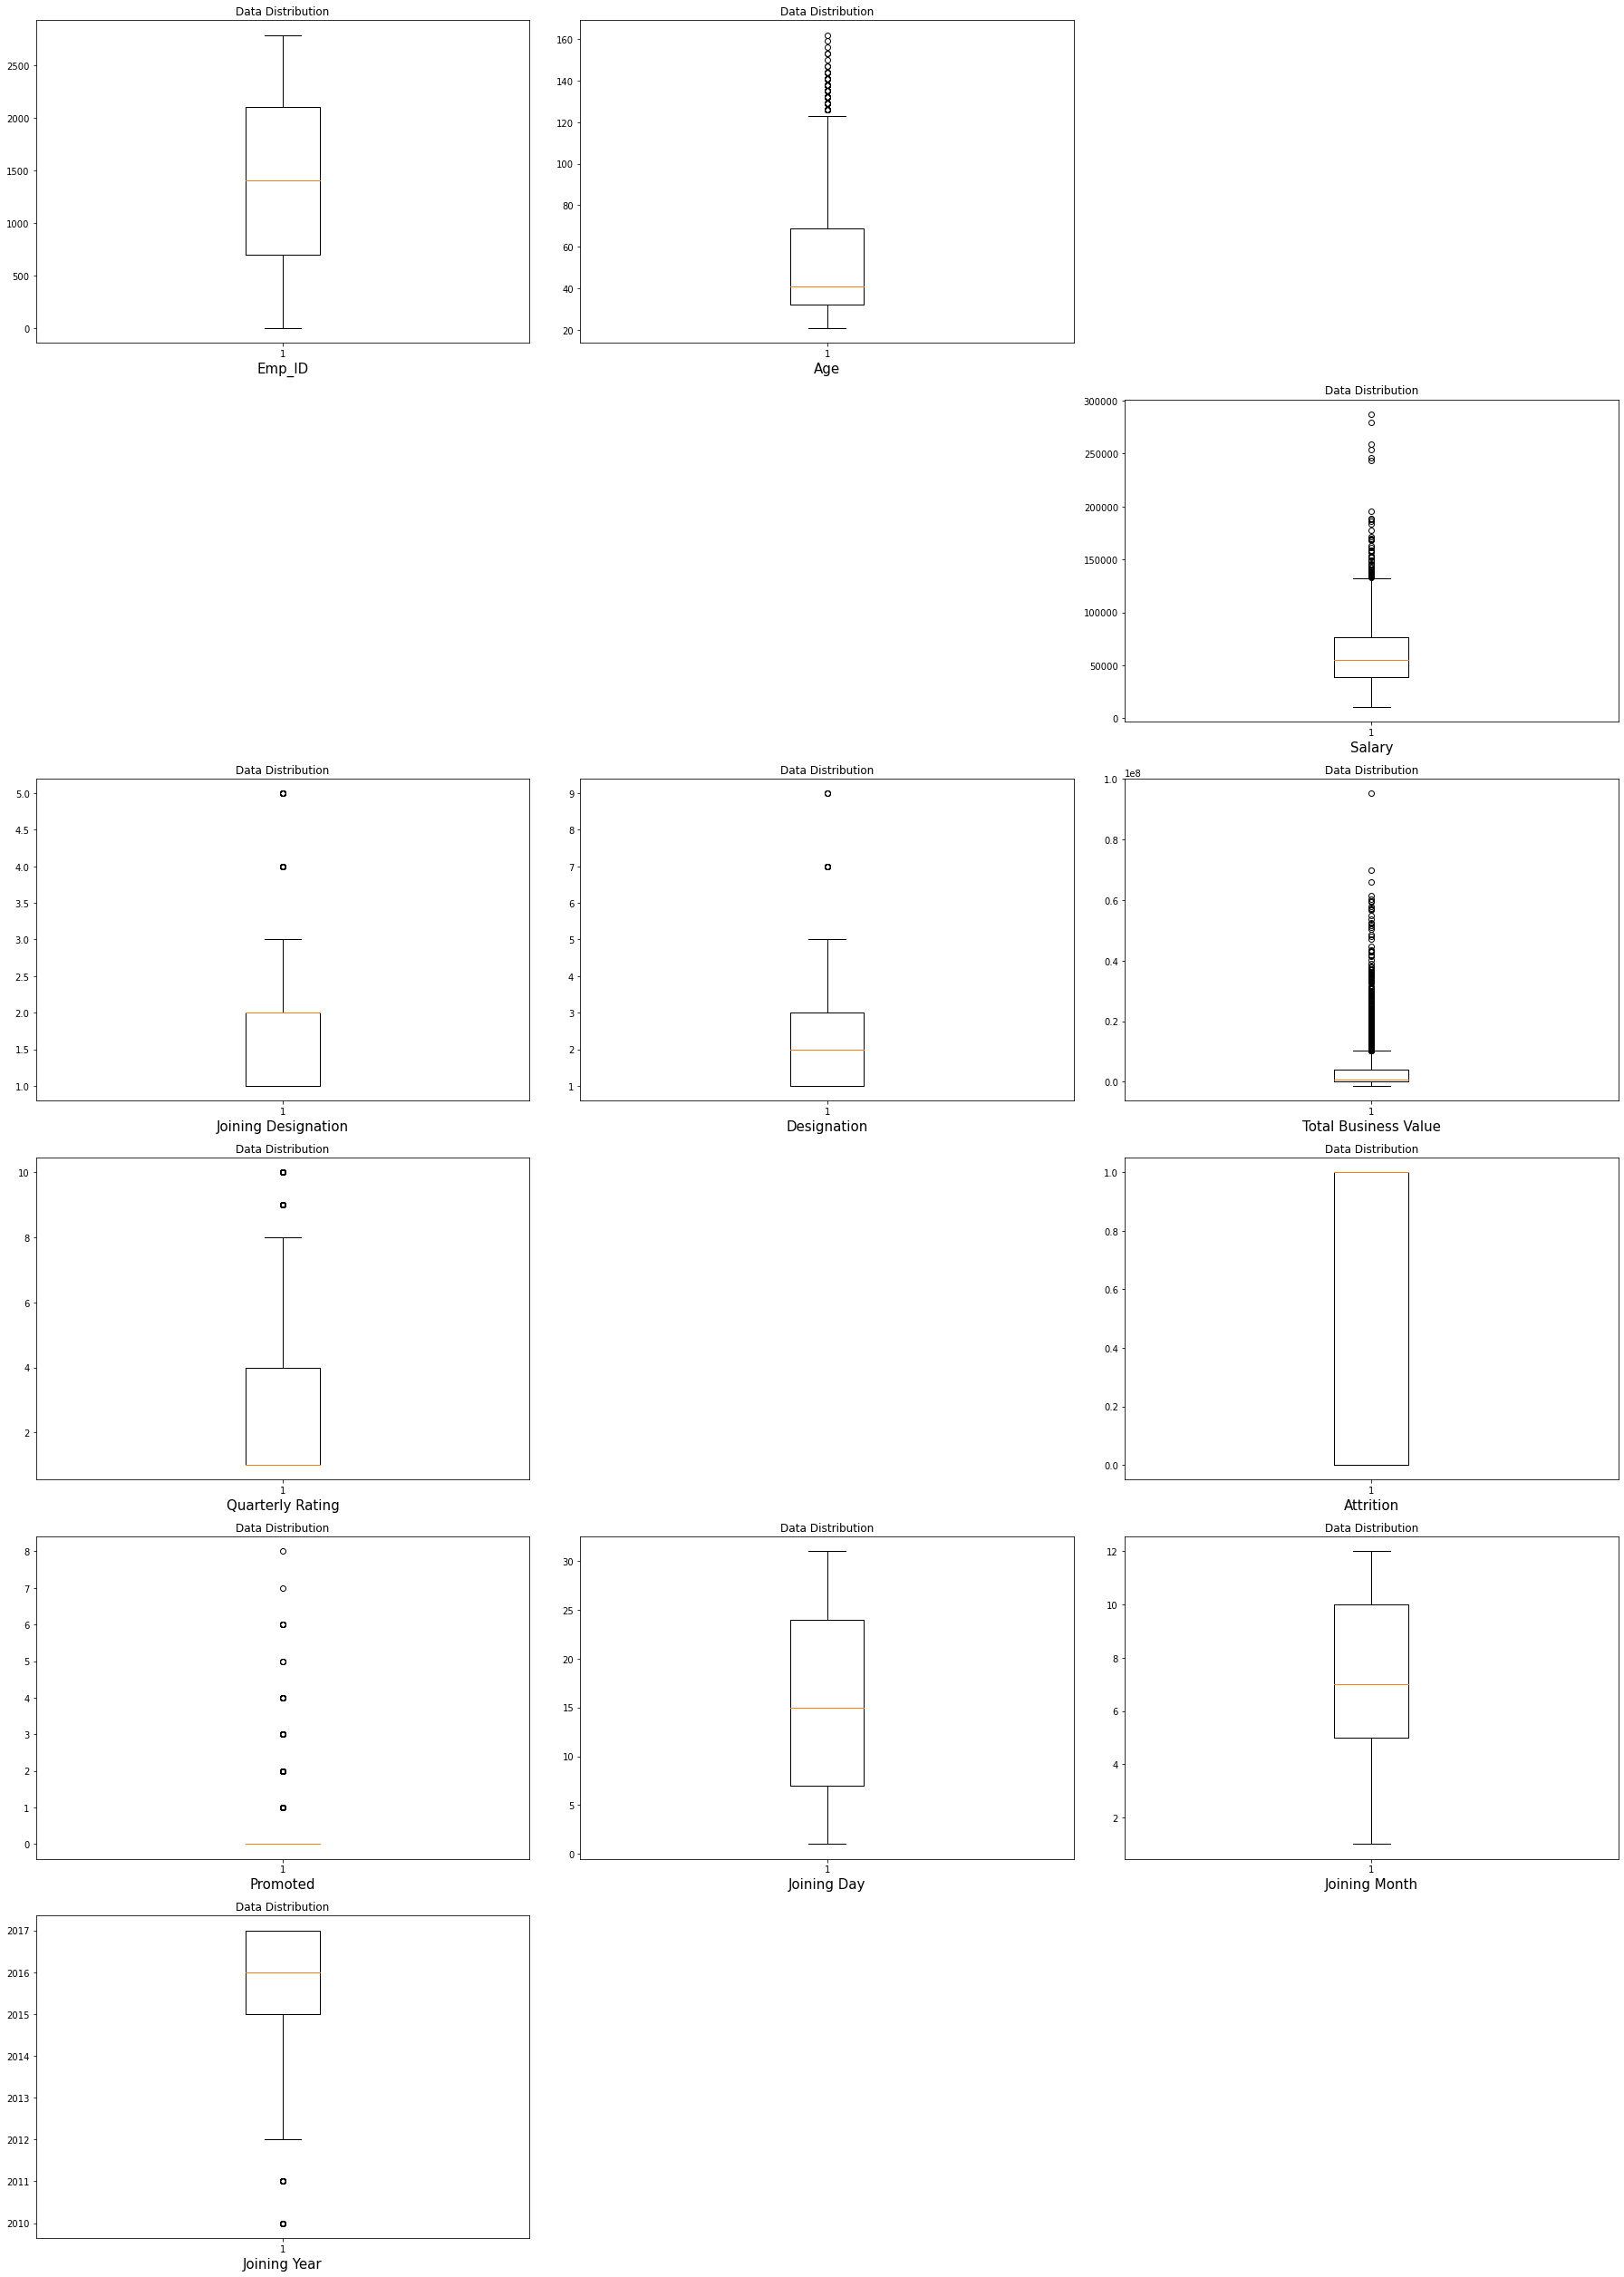

In [22]:
#Checking for outliers in the dataset with the help of box plot only for continuous features.

plt.figure(figsize = [25,35])
plotnumber = 1

for column in df2:
    if df2[column].dtypes=="int64" or df2[column].dtypes=="float64" and plotnumber<=16:
        ax = plt.subplot(6,3,plotnumber)
        plt.boxplot(x = df2[column])
        plt.xlabel(column, fontsize = 15)
        plt.title("Data Distribution", fontsize = 12)
    plotnumber += 1
plt.tight_layout()

**Outliers are found in the features Salary, Total Business Value and Age**

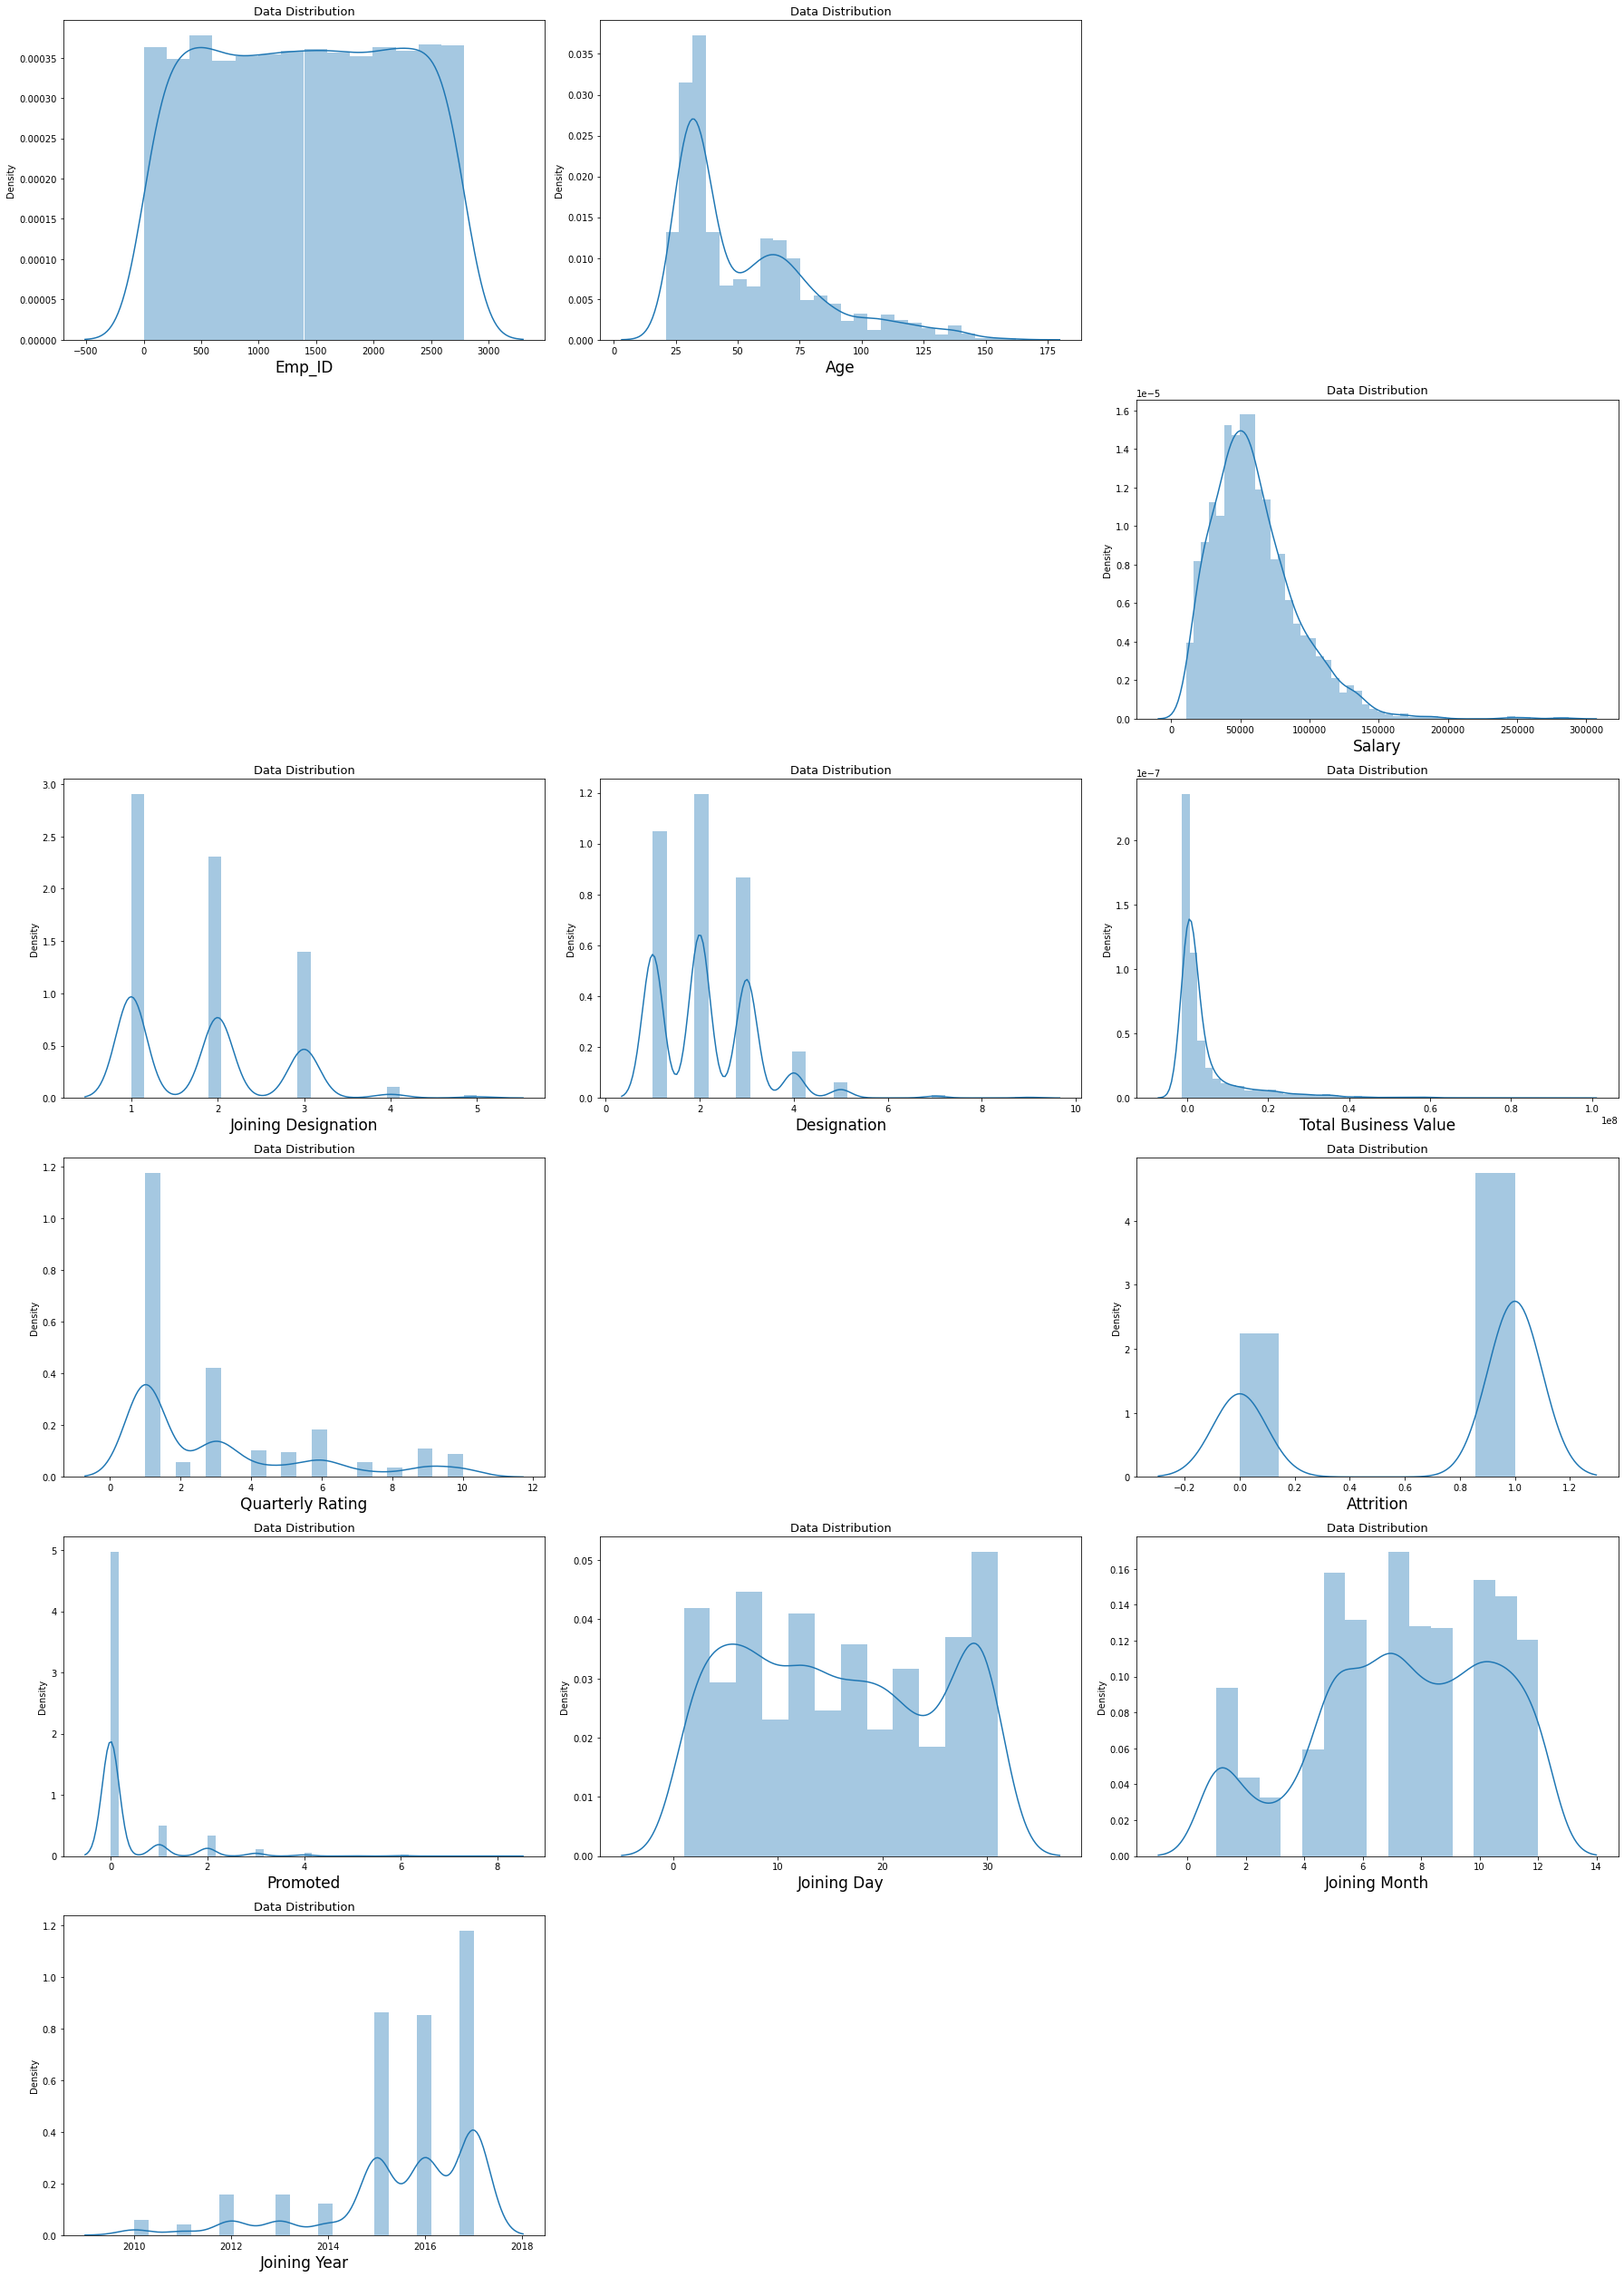

In [23]:
#Let's now check for skewness in the dataset

plt.figure(figsize=[25,35])
plotnumber = 1

for column in df2:
    if df2[column].dtypes=="int64" or df2[column].dtypes=="float64" and plotnumber<=16:
        ax = plt.subplot(6,3,plotnumber)
        sns.distplot(df2[column])
        plt.xlabel(column,fontsize=17)
        plt.title("Data Distribution", fontsize = 13)
    plotnumber+=1
plt.tight_layout()

In [25]:
df2.skew() #checking skewness in the dataset.

Emp_ID                 -0.003884
Age                     1.214731
Salary                  1.421245
Joining Designation     0.687900
Designation             1.173639
Total Business Value    3.374370
Quarterly Rating        1.223823
Tenurity                2.053035
Attrition              -0.765864
Promoted                3.500004
Joining Day             0.097936
Joining Month          -0.371510
Joining Year           -1.414548
dtype: float64

**Skewness is found in the features Salary, Total Business Value and Age**

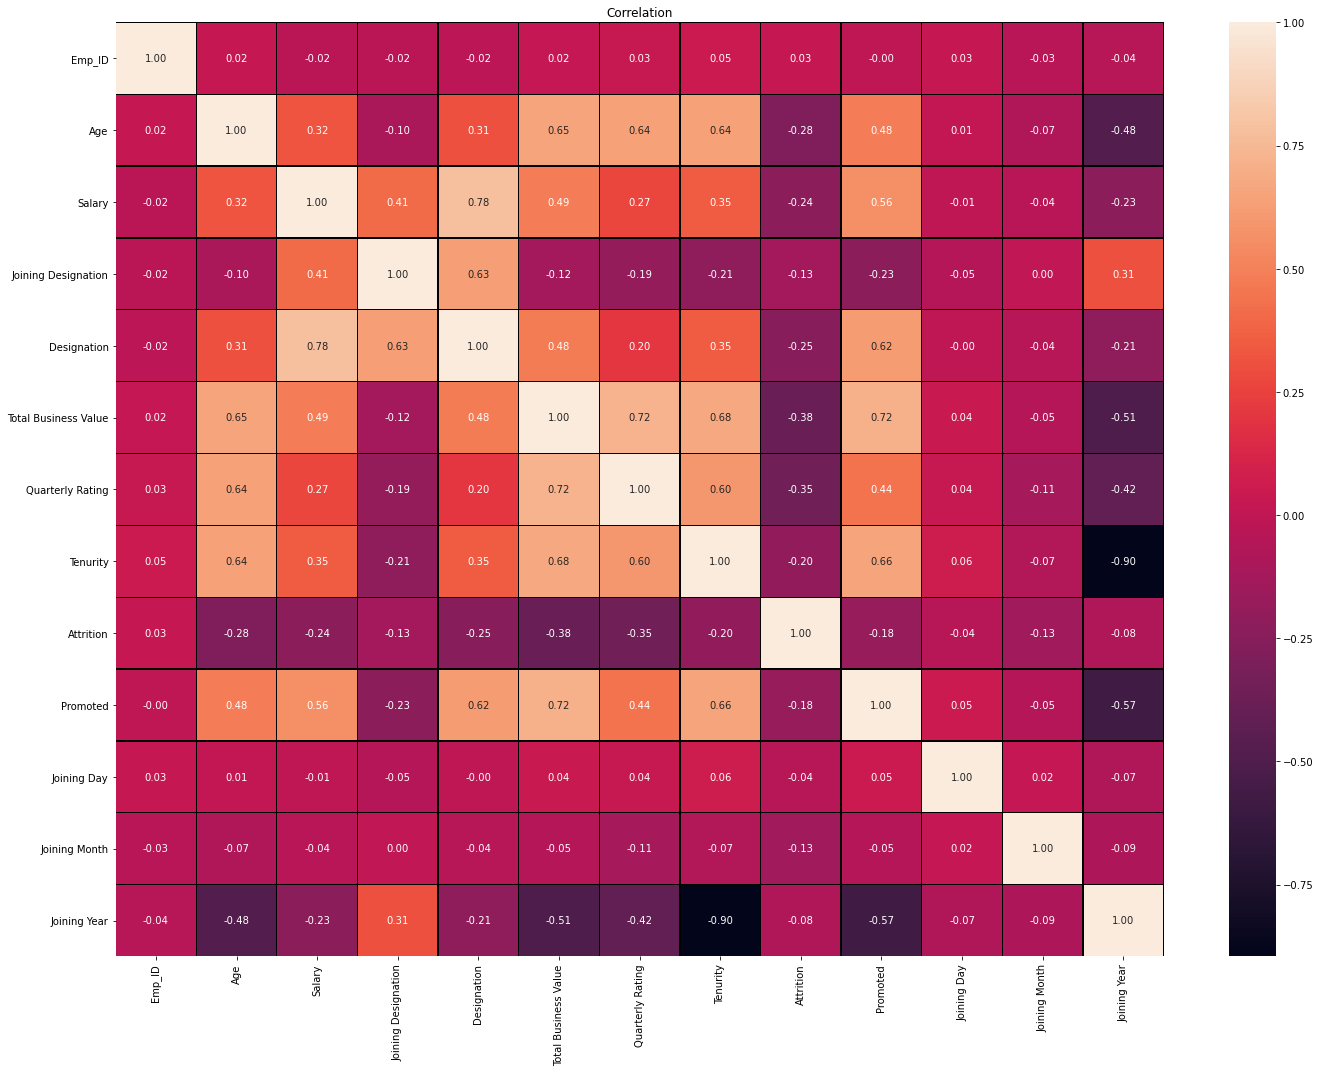

In [28]:
#Let's check for co-relation among features

plt.figure(figsize = [20,15])
sns.heatmap(df2.corr(),annot=True, linewidths=0.3,linecolor="black",fmt='.2f')
plt.title('Correlation')
plt.tight_layout()

**There isn't any co-linearity found among the features**

**Data-Preprocessing**

In [184]:
#Dropped off the columns Emp_ID and Designation as after checking everyting are not found to be important.
df3 = df2.drop(['Emp_ID'], axis = 1)

In [185]:
#Removing Skewness

q = df3['Age'].quantile(0.98)
df3 = df3[df3['Age']<q]

q = df3['Salary'].quantile(0.98)
df3 = df3[df3['Salary']<q]

q = df3['Total Business Value'].quantile(0.96)
df3 = df3[df3['Total Business Value']<q]

q = df3['Tenurity'].quantile(0.97)
df3 = df3[df3['Tenurity']<q]

df3.skew()

Age                     1.141286
Salary                  0.615554
Joining Designation     0.523586
Designation             0.416935
Total Business Value    2.560343
Quarterly Rating        1.552222
Tenurity                2.283542
Attrition              -1.008320
Promoted                3.993305
Joining Day             0.121089
Joining Month          -0.359061
Joining Year           -1.094767
dtype: float64

In [186]:
#Removing outliers with the help of Z-score Method.

from scipy import stats

z = np.abs(stats.zscore(df3['Total Business Value']))
i = np.where(z>3)[0]

print(i)

[  53   70  104  294  305  440  441  505  585  632  673  677  685  719
  743  749  752  795  796  816  841  851  852  916  955 1041 1077 1091
 1117 1163 1276 1305 1307 1376 1379 1398 1406 1411 1412 1425 1473 1496
 1546 1563 1585 1606 1611 1657 1667 1701 1727 1819 1832 1877 1903 1907
 1943 1976 1979 2011 2056 2082]


In [187]:
df3 = df3.drop(df3.index[i]) # Removing the indexes from the entire datatset.
df3.head(2)

,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
0,28,Male,C23,Master,57387,1,1,1715580,2,78,1,0,24,12,2015
1,31,Male,C7,Master,67016,2,2,0,1,55,0,0,6,11,2017


In [188]:
#Doing label encoding for Education_level column

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df3['Education_Level'] = le.fit_transform(df3['Education_Level'])
df3.head(4)

,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
0,28,Male,C23,2,57387,1,1,1715580,2,78,1,0,24,12,2015
1,31,Male,C7,2,67016,2,2,0,1,55,0,0,6,11,2017
2,43,Male,C13,2,65603,2,2,350000,1,141,1,0,7,12,2016
3,29,Male,C9,1,46368,1,1,120360,1,58,1,0,9,1,2016


In [189]:
final_train = pd.get_dummies(data = df3, columns = ['Gender','City'])
final_train

,Age,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28,2,57387,1,1,1715580,2,78,1,0,...,0,0,0,0,0,0,0,0,0,0
1,31,2,67016,2,2,0,1,55,0,0,...,0,0,0,0,0,0,0,1,0,0
2,43,2,65603,2,2,350000,1,141,1,0,...,0,0,0,0,0,0,0,0,0,0
3,29,1,46368,1,1,120360,1,58,1,0,...,0,0,0,0,0,0,0,0,0,1
4,31,0,78728,3,3,1265000,3,153,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,26,0,29582,1,1,0,1,92,1,0,...,0,0,0,0,0,0,0,0,0,0
2377,34,1,12105,1,1,0,1,61,1,0,...,0,0,0,0,0,0,0,0,0,1
2378,89,1,35370,2,2,2815090,3,419,1,0,...,0,0,0,0,0,0,0,0,0,0
2379,28,2,69498,1,1,977830,3,335,1,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
#Separating Features and Labels into x and y

x = final_train.drop(['Attrition'], axis = 1)
y = final_train['Attrition']

In [191]:
#Data Balancing using Smote as there was lot of imbalance in the labe;
from imblearn.over_sampling import SMOTE
oversample=SMOTE(k_neighbors = 4)
X, Y = oversample.fit_resample(x, y)
Y.value_counts()

0    1527
1    1527
Name: Attrition, dtype: int64

In [192]:
#Scaling the data for building our model.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

**Model Building**

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

In [96]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve

In [193]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y, test_size = 0.20, random_state = 100)

In [194]:
rf = RandomForestClassifier()
xgb = XGBClassifier()
cb = CatBoostClassifier(learning_rate = 0.01, depth=8)
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svc = SVC()

In [195]:
#training with random forest classifier and checking the scores
rf.fit(x_train,y_train)
print('RandomForestClassifier score =', rf.score(x_test,y_test))
print('\n\n RandomForestClassifier accuracy =', accuracy_score(y_test,rf.predict(x_test)))
print('\n\n Classification report of RandomForestClassifier \n', classification_report(y_test,rf.predict(x_test)))
print('Confusion Matrix of Random Forest \n', confusion_matrix(y_test,rf.predict(x_test)))
print('Random Forest Roc_auc_Score=', roc_auc_score(y_test,rf.predict(x_test)))

RandomForestClassifier score = 0.9361702127659575


 RandomForestClassifier accuracy = 0.9361702127659575


 Classification report of RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       300
           1       0.97      0.90      0.94       311

    accuracy                           0.94       611
   macro avg       0.94      0.94      0.94       611
weighted avg       0.94      0.94      0.94       611

Confusion Matrix of Random Forest 
 [[291   9]
 [ 30 281]]
Random Forest Roc_auc_Score= 0.9367684887459807


In [196]:
#training with XGBClassifier and checking the scores
xgb.fit(x_train,y_train)
print('XGBClassifier score =', xgb.score(x_test,y_test))
print('\n\n XGBClassifier accuracy =', accuracy_score(y_test,xgb.predict(x_test)))
print('\n\n Classification report of XGBClassifier \n', classification_report(y_test,xgb.predict(x_test)))
print('Confusion Matrix of Xtreme Gradient Boost \n', confusion_matrix(y_test,xgb.predict(x_test)))
print('Xtreme Gradient Boost Roc_auc_Score=', roc_auc_score(y_test,xgb.predict(x_test)))

[20:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier score = 0.9574468085106383


 XGBClassifier accuracy = 0.9574468085106383


 Classification report of XGBClassifier 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       300
           1       0.98      0.94      0.96       311

    accuracy                           0.96       611
   macro avg       0.96      0.96      0.96       611
weighted avg       0.96      0.96      0.96       611

Confusion Matrix of Xtreme Gradient Boost 
 [[294   6]
 [ 20 291]]
Xtreme Gradient Boost Roc_auc_Score= 0.957845659163987


In [197]:
#training with CatBoostClassifier and checking the scores
cb.fit(x_train,y_train)
print('CatBoostClassifier score =', cb.score(x_test,y_test))
print('\n\n CatBoostClassifier accuracy =', accuracy_score(y_test,cb.predict(x_test)))
print('\n\n Classification report of CatBoostClassifier \n', classification_report(y_test,cb.predict(x_test)))
print('Confusion Matrix of CatBoostClassifier \n', confusion_matrix(y_test,cb.predict(x_test)))
print('CatBoostClassifier Roc_auc_Score=', roc_auc_score(y_test,cb.predict(x_test)))

0:	learn: 0.6818421	total: 15.3ms	remaining: 15.3s
1:	learn: 0.6715127	total: 23.2ms	remaining: 11.6s
2:	learn: 0.6625148	total: 30.3ms	remaining: 10.1s
3:	learn: 0.6533009	total: 37.9ms	remaining: 9.43s
4:	learn: 0.6439796	total: 60.8ms	remaining: 12.1s
5:	learn: 0.6357981	total: 68.6ms	remaining: 11.4s
6:	learn: 0.6279051	total: 75.9ms	remaining: 10.8s
7:	learn: 0.6184916	total: 83.5ms	remaining: 10.4s
8:	learn: 0.6099119	total: 90.5ms	remaining: 9.97s
9:	learn: 0.6025624	total: 98.3ms	remaining: 9.73s
10:	learn: 0.5941985	total: 106ms	remaining: 9.49s
11:	learn: 0.5852179	total: 113ms	remaining: 9.31s
12:	learn: 0.5772505	total: 120ms	remaining: 9.14s
13:	learn: 0.5695765	total: 128ms	remaining: 9s
14:	learn: 0.5622664	total: 135ms	remaining: 8.87s
15:	learn: 0.5559204	total: 142ms	remaining: 8.76s
16:	learn: 0.5482392	total: 150ms	remaining: 8.65s
17:	learn: 0.5416407	total: 157ms	remaining: 8.55s
18:	learn: 0.5347687	total: 166ms	remaining: 8.57s
19:	learn: 0.5279454	total: 174ms	

171:	learn: 0.2047603	total: 1.59s	remaining: 7.66s
172:	learn: 0.2041219	total: 1.61s	remaining: 7.71s
173:	learn: 0.2033989	total: 1.63s	remaining: 7.72s
174:	learn: 0.2025380	total: 1.64s	remaining: 7.71s
175:	learn: 0.2021884	total: 1.64s	remaining: 7.7s
176:	learn: 0.2017052	total: 1.65s	remaining: 7.68s
177:	learn: 0.2012249	total: 1.66s	remaining: 7.67s
178:	learn: 0.2007773	total: 1.67s	remaining: 7.65s
179:	learn: 0.2001933	total: 1.68s	remaining: 7.63s
180:	learn: 0.1995569	total: 1.68s	remaining: 7.62s
181:	learn: 0.1989307	total: 1.69s	remaining: 7.6s
182:	learn: 0.1984776	total: 1.7s	remaining: 7.58s
183:	learn: 0.1979968	total: 1.71s	remaining: 7.57s
184:	learn: 0.1976489	total: 1.8s	remaining: 7.93s
185:	learn: 0.1971779	total: 1.83s	remaining: 8s
186:	learn: 0.1965219	total: 1.85s	remaining: 8.03s
187:	learn: 0.1959283	total: 1.86s	remaining: 8.02s
188:	learn: 0.1954753	total: 1.86s	remaining: 8s
189:	learn: 0.1947964	total: 1.87s	remaining: 7.98s
190:	learn: 0.1944581	

350:	learn: 0.1443748	total: 3.4s	remaining: 6.29s
351:	learn: 0.1441969	total: 3.42s	remaining: 6.29s
352:	learn: 0.1440318	total: 3.43s	remaining: 6.29s
353:	learn: 0.1437484	total: 3.44s	remaining: 6.29s
354:	learn: 0.1434478	total: 3.46s	remaining: 6.28s
355:	learn: 0.1432601	total: 3.47s	remaining: 6.27s
356:	learn: 0.1429935	total: 3.48s	remaining: 6.26s
357:	learn: 0.1428946	total: 3.49s	remaining: 6.25s
358:	learn: 0.1426248	total: 3.5s	remaining: 6.25s
359:	learn: 0.1423550	total: 3.51s	remaining: 6.24s
360:	learn: 0.1421741	total: 3.52s	remaining: 6.22s
361:	learn: 0.1420302	total: 3.53s	remaining: 6.21s
362:	learn: 0.1419066	total: 3.54s	remaining: 6.21s
363:	learn: 0.1416665	total: 3.55s	remaining: 6.2s
364:	learn: 0.1413861	total: 3.56s	remaining: 6.19s
365:	learn: 0.1411940	total: 3.57s	remaining: 6.18s
366:	learn: 0.1409796	total: 3.58s	remaining: 6.17s
367:	learn: 0.1407967	total: 3.58s	remaining: 6.16s
368:	learn: 0.1405985	total: 3.6s	remaining: 6.15s
369:	learn: 0.14

522:	learn: 0.1147052	total: 5.16s	remaining: 4.7s
523:	learn: 0.1145008	total: 5.17s	remaining: 4.69s
524:	learn: 0.1143366	total: 5.18s	remaining: 4.68s
525:	learn: 0.1141786	total: 5.19s	remaining: 4.68s
526:	learn: 0.1140280	total: 5.2s	remaining: 4.67s
527:	learn: 0.1139024	total: 5.21s	remaining: 4.66s
528:	learn: 0.1138302	total: 5.22s	remaining: 4.65s
529:	learn: 0.1137265	total: 5.23s	remaining: 4.64s
530:	learn: 0.1135856	total: 5.24s	remaining: 4.63s
531:	learn: 0.1134635	total: 5.25s	remaining: 4.62s
532:	learn: 0.1133082	total: 5.26s	remaining: 4.61s
533:	learn: 0.1132010	total: 5.27s	remaining: 4.6s
534:	learn: 0.1130946	total: 5.28s	remaining: 4.59s
535:	learn: 0.1129960	total: 5.29s	remaining: 4.58s
536:	learn: 0.1127960	total: 5.3s	remaining: 4.57s
537:	learn: 0.1127021	total: 5.31s	remaining: 4.56s
538:	learn: 0.1125413	total: 5.32s	remaining: 4.55s
539:	learn: 0.1123323	total: 5.33s	remaining: 4.54s
540:	learn: 0.1122323	total: 5.34s	remaining: 4.53s
541:	learn: 0.11

694:	learn: 0.0945378	total: 7.09s	remaining: 3.11s
695:	learn: 0.0944729	total: 7.1s	remaining: 3.1s
696:	learn: 0.0943841	total: 7.11s	remaining: 3.09s
697:	learn: 0.0943204	total: 7.12s	remaining: 3.08s
698:	learn: 0.0942375	total: 7.13s	remaining: 3.07s
699:	learn: 0.0941705	total: 7.14s	remaining: 3.06s
700:	learn: 0.0940835	total: 7.15s	remaining: 3.05s
701:	learn: 0.0940208	total: 7.16s	remaining: 3.04s
702:	learn: 0.0939294	total: 7.16s	remaining: 3.03s
703:	learn: 0.0938355	total: 7.17s	remaining: 3.02s
704:	learn: 0.0936622	total: 7.18s	remaining: 3s
705:	learn: 0.0935964	total: 7.19s	remaining: 2.99s
706:	learn: 0.0935107	total: 7.2s	remaining: 2.98s
707:	learn: 0.0934216	total: 7.21s	remaining: 2.97s
708:	learn: 0.0932090	total: 7.22s	remaining: 2.96s
709:	learn: 0.0930416	total: 7.23s	remaining: 2.95s
710:	learn: 0.0929818	total: 7.24s	remaining: 2.94s
711:	learn: 0.0928779	total: 7.25s	remaining: 2.93s
712:	learn: 0.0927502	total: 7.25s	remaining: 2.92s
713:	learn: 0.0925

862:	learn: 0.0808597	total: 8.8s	remaining: 1.4s
863:	learn: 0.0807235	total: 8.81s	remaining: 1.39s
864:	learn: 0.0806649	total: 8.82s	remaining: 1.38s
865:	learn: 0.0805504	total: 8.83s	remaining: 1.37s
866:	learn: 0.0805365	total: 8.84s	remaining: 1.36s
867:	learn: 0.0804773	total: 8.85s	remaining: 1.35s
868:	learn: 0.0804395	total: 8.87s	remaining: 1.34s
869:	learn: 0.0803473	total: 8.88s	remaining: 1.33s
870:	learn: 0.0801986	total: 8.89s	remaining: 1.32s
871:	learn: 0.0801446	total: 8.9s	remaining: 1.31s
872:	learn: 0.0801300	total: 8.91s	remaining: 1.3s
873:	learn: 0.0800893	total: 8.93s	remaining: 1.29s
874:	learn: 0.0800235	total: 8.94s	remaining: 1.28s
875:	learn: 0.0799615	total: 8.95s	remaining: 1.27s
876:	learn: 0.0798530	total: 8.96s	remaining: 1.26s
877:	learn: 0.0798104	total: 8.97s	remaining: 1.25s
878:	learn: 0.0796934	total: 8.97s	remaining: 1.24s
879:	learn: 0.0796482	total: 8.99s	remaining: 1.23s
880:	learn: 0.0796288	total: 8.99s	remaining: 1.21s
881:	learn: 0.07

In [198]:
#training with DecisionTreeClassifier and checking the scores
dt.fit(x_train,y_train)
print('DecisionTreeClassifier score =', dt.score(x_test,y_test))
print('\n\n DecisionTreeClassifier accuracy =', accuracy_score(y_test,dt.predict(x_test)))
print('\n\n Classification report of DecisionTreeClassifier \n', classification_report(y_test,dt.predict(x_test)))
print('Confusion Matrix of Decision Tree\n', confusion_matrix(y_test,dt.predict(x_test)))
print('Decision Tree Roc_auc_Score=', roc_auc_score(y_test,dt.predict(x_test)))

DecisionTreeClassifier score = 0.9165302782324058


 DecisionTreeClassifier accuracy = 0.9165302782324058


 Classification report of DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       300
           1       0.92      0.91      0.92       311

    accuracy                           0.92       611
   macro avg       0.92      0.92      0.92       611
weighted avg       0.92      0.92      0.92       611

Confusion Matrix of Decision Tree
 [[277  23]
 [ 28 283]]
Decision Tree Roc_auc_Score= 0.9166505894962487


In [199]:
#training with LogisticRegression and checking the scores
lr.fit(x_train,y_train)
print('LogisticRegression score =', lr.score(x_test,y_test))
print('\n\n LogisticRegression accuracy =', accuracy_score(y_test,lr.predict(x_test)))
print('\n\n Classification report of LogisticRegression \n', classification_report(y_test,lr.predict(x_test)))
print('Confusion Matrix of Logistic Regression\n', confusion_matrix(y_test,lr.predict(x_test)))
print('Logistic Regression Roc_auc_Score =', roc_auc_score(y_test,lr.predict(x_test)))

LogisticRegression score = 0.9623567921440261


 LogisticRegression accuracy = 0.9623567921440261


 Classification report of LogisticRegression 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       300
           1       0.99      0.94      0.96       311

    accuracy                           0.96       611
   macro avg       0.96      0.96      0.96       611
weighted avg       0.96      0.96      0.96       611

Confusion Matrix of Logistic Regression
 [[296   4]
 [ 19 292]]
Logistic Regression Roc_auc_Score = 0.962786709539121


Plotting ROC_AUC_CURVE for each algorithm to check and see which one of them is covering the most area

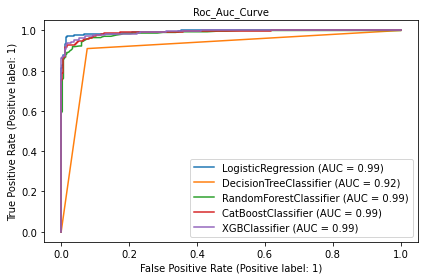

In [200]:
curve = plot_roc_curve(lr,x_test,y_test)

plot_roc_curve(dt,x_test,y_test,ax=curve.ax_)

plot_roc_curve(rf,x_test,y_test,ax=curve.ax_)

plot_roc_curve(cb,x_test,y_test,ax=curve.ax_)

plot_roc_curve(xgb,x_test,y_test,ax=curve.ax_)

plt.title('Roc_Auc_Curve', fontsize = 10)
plt.tight_layout()

**From the plot it is clearly visible that Logistic regression, CatBoostClassifier and XtremeGradientBoosting is covering the most area and also the other scores which we have measured are better than other algorithms hence we will hypertune it further**

In [201]:
#Doing Cross Validation for the 3 models which are covering the most roc_auc_curve to see if the model is overfitting or underfitting.

from sklearn.model_selection import cross_val_score

print('Xtreme Gradient Boost Classifier Cross Validation Score ==', cross_val_score(xgb,x_scaled,Y,cv=3).mean())
print('\n\n Logistic Regression Cross Validation Score ==', cross_val_score(lr,x_scaled,Y,cv=3).mean())
print('\n\n CatBoost Classifier Cross Validation Score ==', cross_val_score(cb,x_scaled,Y,cv=3).mean())

[20:25:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xtreme Gradient Boost Classifier Cross Validation Score == 0.937131630

148:	learn: 0.2074183	total: 1.15s	remaining: 6.56s
149:	learn: 0.2066127	total: 1.16s	remaining: 6.55s
150:	learn: 0.2060430	total: 1.17s	remaining: 6.55s
151:	learn: 0.2050907	total: 1.18s	remaining: 6.56s
152:	learn: 0.2043176	total: 1.18s	remaining: 6.55s
153:	learn: 0.2037454	total: 1.19s	remaining: 6.54s
154:	learn: 0.2029905	total: 1.2s	remaining: 6.53s
155:	learn: 0.2022343	total: 1.21s	remaining: 6.53s
156:	learn: 0.2012602	total: 1.21s	remaining: 6.52s
157:	learn: 0.2007010	total: 1.22s	remaining: 6.51s
158:	learn: 0.1997619	total: 1.23s	remaining: 6.5s
159:	learn: 0.1990146	total: 1.24s	remaining: 6.49s
160:	learn: 0.1984452	total: 1.25s	remaining: 6.49s
161:	learn: 0.1980672	total: 1.25s	remaining: 6.48s
162:	learn: 0.1974356	total: 1.26s	remaining: 6.48s
163:	learn: 0.1969109	total: 1.27s	remaining: 6.47s
164:	learn: 0.1965233	total: 1.28s	remaining: 6.47s
165:	learn: 0.1956616	total: 1.28s	remaining: 6.46s
166:	learn: 0.1948901	total: 1.29s	remaining: 6.45s
167:	learn: 0.

307:	learn: 0.1423397	total: 2.42s	remaining: 5.44s
308:	learn: 0.1420169	total: 2.43s	remaining: 5.43s
309:	learn: 0.1418311	total: 2.44s	remaining: 5.42s
310:	learn: 0.1417138	total: 2.44s	remaining: 5.42s
311:	learn: 0.1414290	total: 2.45s	remaining: 5.41s
312:	learn: 0.1411661	total: 2.46s	remaining: 5.4s
313:	learn: 0.1408196	total: 2.47s	remaining: 5.4s
314:	learn: 0.1406120	total: 2.48s	remaining: 5.39s
315:	learn: 0.1404049	total: 2.48s	remaining: 5.38s
316:	learn: 0.1402428	total: 2.49s	remaining: 5.37s
317:	learn: 0.1399590	total: 2.5s	remaining: 5.36s
318:	learn: 0.1397058	total: 2.51s	remaining: 5.36s
319:	learn: 0.1395473	total: 2.52s	remaining: 5.35s
320:	learn: 0.1393746	total: 2.52s	remaining: 5.34s
321:	learn: 0.1391475	total: 2.53s	remaining: 5.33s
322:	learn: 0.1388052	total: 2.54s	remaining: 5.32s
323:	learn: 0.1385047	total: 2.55s	remaining: 5.32s
324:	learn: 0.1383354	total: 2.56s	remaining: 5.31s
325:	learn: 0.1380707	total: 2.56s	remaining: 5.3s
326:	learn: 0.13

471:	learn: 0.1080459	total: 3.71s	remaining: 4.15s
472:	learn: 0.1079160	total: 3.72s	remaining: 4.14s
473:	learn: 0.1077656	total: 3.73s	remaining: 4.14s
474:	learn: 0.1075937	total: 3.74s	remaining: 4.13s
475:	learn: 0.1074220	total: 3.75s	remaining: 4.12s
476:	learn: 0.1072395	total: 3.75s	remaining: 4.12s
477:	learn: 0.1071435	total: 3.76s	remaining: 4.11s
478:	learn: 0.1069110	total: 3.77s	remaining: 4.1s
479:	learn: 0.1066295	total: 3.77s	remaining: 4.09s
480:	learn: 0.1064079	total: 3.78s	remaining: 4.08s
481:	learn: 0.1062820	total: 3.79s	remaining: 4.07s
482:	learn: 0.1061466	total: 3.8s	remaining: 4.06s
483:	learn: 0.1057984	total: 3.8s	remaining: 4.05s
484:	learn: 0.1055488	total: 3.81s	remaining: 4.05s
485:	learn: 0.1053628	total: 3.82s	remaining: 4.04s
486:	learn: 0.1052385	total: 3.83s	remaining: 4.03s
487:	learn: 0.1050662	total: 3.83s	remaining: 4.02s
488:	learn: 0.1049546	total: 3.84s	remaining: 4.01s
489:	learn: 0.1047614	total: 3.85s	remaining: 4s
490:	learn: 0.1046

654:	learn: 0.0842984	total: 5.08s	remaining: 2.67s
655:	learn: 0.0842163	total: 5.08s	remaining: 2.67s
656:	learn: 0.0841397	total: 5.09s	remaining: 2.66s
657:	learn: 0.0840393	total: 5.1s	remaining: 2.65s
658:	learn: 0.0840031	total: 5.11s	remaining: 2.64s
659:	learn: 0.0839441	total: 5.11s	remaining: 2.63s
660:	learn: 0.0837910	total: 5.12s	remaining: 2.63s
661:	learn: 0.0837034	total: 5.13s	remaining: 2.62s
662:	learn: 0.0836037	total: 5.13s	remaining: 2.61s
663:	learn: 0.0834727	total: 5.14s	remaining: 2.6s
664:	learn: 0.0833187	total: 5.15s	remaining: 2.59s
665:	learn: 0.0831676	total: 5.16s	remaining: 2.59s
666:	learn: 0.0830840	total: 5.17s	remaining: 2.58s
667:	learn: 0.0829866	total: 5.18s	remaining: 2.57s
668:	learn: 0.0828681	total: 5.18s	remaining: 2.56s
669:	learn: 0.0827452	total: 5.19s	remaining: 2.56s
670:	learn: 0.0826238	total: 5.2s	remaining: 2.55s
671:	learn: 0.0824628	total: 5.21s	remaining: 2.54s
672:	learn: 0.0823727	total: 5.21s	remaining: 2.53s
673:	learn: 0.0

833:	learn: 0.0675513	total: 6.41s	remaining: 1.28s
834:	learn: 0.0674307	total: 6.42s	remaining: 1.27s
835:	learn: 0.0673394	total: 6.43s	remaining: 1.26s
836:	learn: 0.0672486	total: 6.44s	remaining: 1.25s
837:	learn: 0.0671272	total: 6.44s	remaining: 1.25s
838:	learn: 0.0670564	total: 6.45s	remaining: 1.24s
839:	learn: 0.0669873	total: 6.46s	remaining: 1.23s
840:	learn: 0.0669203	total: 6.47s	remaining: 1.22s
841:	learn: 0.0668314	total: 6.47s	remaining: 1.21s
842:	learn: 0.0667526	total: 6.48s	remaining: 1.21s
843:	learn: 0.0666667	total: 6.49s	remaining: 1.2s
844:	learn: 0.0665833	total: 6.5s	remaining: 1.19s
845:	learn: 0.0665327	total: 6.5s	remaining: 1.18s
846:	learn: 0.0664022	total: 6.51s	remaining: 1.18s
847:	learn: 0.0663608	total: 6.52s	remaining: 1.17s
848:	learn: 0.0663011	total: 6.53s	remaining: 1.16s
849:	learn: 0.0662094	total: 6.53s	remaining: 1.15s
850:	learn: 0.0661332	total: 6.54s	remaining: 1.15s
851:	learn: 0.0660489	total: 6.55s	remaining: 1.14s
852:	learn: 0.0

0:	learn: 0.6826004	total: 7.7ms	remaining: 7.69s
1:	learn: 0.6731597	total: 15.3ms	remaining: 7.63s
2:	learn: 0.6648087	total: 21.9ms	remaining: 7.27s
3:	learn: 0.6545087	total: 29ms	remaining: 7.23s
4:	learn: 0.6459488	total: 36ms	remaining: 7.17s
5:	learn: 0.6367137	total: 43ms	remaining: 7.12s
6:	learn: 0.6289033	total: 50ms	remaining: 7.09s
7:	learn: 0.6210052	total: 57.1ms	remaining: 7.08s
8:	learn: 0.6127532	total: 63.7ms	remaining: 7.01s
9:	learn: 0.6048695	total: 70.9ms	remaining: 7.01s
10:	learn: 0.5959302	total: 77.9ms	remaining: 7s
11:	learn: 0.5866494	total: 85ms	remaining: 7s
12:	learn: 0.5779679	total: 92.6ms	remaining: 7.03s
13:	learn: 0.5700241	total: 99.7ms	remaining: 7.02s
14:	learn: 0.5632684	total: 108ms	remaining: 7.07s
15:	learn: 0.5567879	total: 115ms	remaining: 7.06s
16:	learn: 0.5481230	total: 122ms	remaining: 7.06s
17:	learn: 0.5420153	total: 130ms	remaining: 7.07s
18:	learn: 0.5344542	total: 137ms	remaining: 7.07s
19:	learn: 0.5271937	total: 144ms	remaining:

177:	learn: 0.2027404	total: 1.34s	remaining: 6.21s
178:	learn: 0.2019192	total: 1.35s	remaining: 6.2s
179:	learn: 0.2014004	total: 1.36s	remaining: 6.2s
180:	learn: 0.2010292	total: 1.37s	remaining: 6.21s
181:	learn: 0.2006891	total: 1.38s	remaining: 6.2s
182:	learn: 0.2002227	total: 1.39s	remaining: 6.18s
183:	learn: 0.1999211	total: 1.39s	remaining: 6.18s
184:	learn: 0.1992909	total: 1.4s	remaining: 6.17s
185:	learn: 0.1984781	total: 1.41s	remaining: 6.16s
186:	learn: 0.1980416	total: 1.42s	remaining: 6.16s
187:	learn: 0.1973669	total: 1.42s	remaining: 6.15s
188:	learn: 0.1964121	total: 1.43s	remaining: 6.14s
189:	learn: 0.1957957	total: 1.44s	remaining: 6.13s
190:	learn: 0.1955068	total: 1.45s	remaining: 6.12s
191:	learn: 0.1950086	total: 1.45s	remaining: 6.12s
192:	learn: 0.1944012	total: 1.46s	remaining: 6.11s
193:	learn: 0.1938450	total: 1.47s	remaining: 6.1s
194:	learn: 0.1934227	total: 1.48s	remaining: 6.09s
195:	learn: 0.1931109	total: 1.48s	remaining: 6.08s
196:	learn: 0.192

351:	learn: 0.1414912	total: 2.68s	remaining: 4.93s
352:	learn: 0.1412090	total: 2.69s	remaining: 4.93s
353:	learn: 0.1409370	total: 2.69s	remaining: 4.92s
354:	learn: 0.1408129	total: 2.7s	remaining: 4.91s
355:	learn: 0.1406395	total: 2.71s	remaining: 4.9s
356:	learn: 0.1403886	total: 2.72s	remaining: 4.89s
357:	learn: 0.1402061	total: 2.73s	remaining: 4.89s
358:	learn: 0.1399778	total: 2.73s	remaining: 4.88s
359:	learn: 0.1399048	total: 2.74s	remaining: 4.88s
360:	learn: 0.1396213	total: 2.75s	remaining: 4.87s
361:	learn: 0.1394621	total: 2.76s	remaining: 4.86s
362:	learn: 0.1392788	total: 2.76s	remaining: 4.85s
363:	learn: 0.1390254	total: 2.77s	remaining: 4.84s
364:	learn: 0.1388533	total: 2.78s	remaining: 4.83s
365:	learn: 0.1385999	total: 2.79s	remaining: 4.83s
366:	learn: 0.1384559	total: 2.79s	remaining: 4.82s
367:	learn: 0.1382052	total: 2.8s	remaining: 4.81s
368:	learn: 0.1378695	total: 2.81s	remaining: 4.8s
369:	learn: 0.1377666	total: 2.82s	remaining: 4.79s
370:	learn: 0.13

525:	learn: 0.1102542	total: 4.19s	remaining: 3.77s
526:	learn: 0.1101452	total: 4.2s	remaining: 3.77s
527:	learn: 0.1099876	total: 4.2s	remaining: 3.76s
528:	learn: 0.1098549	total: 4.21s	remaining: 3.75s
529:	learn: 0.1096631	total: 4.23s	remaining: 3.75s
530:	learn: 0.1095782	total: 4.24s	remaining: 3.74s
531:	learn: 0.1094715	total: 4.25s	remaining: 3.74s
532:	learn: 0.1093544	total: 4.26s	remaining: 3.73s
533:	learn: 0.1093080	total: 4.27s	remaining: 3.72s
534:	learn: 0.1092062	total: 4.28s	remaining: 3.72s
535:	learn: 0.1090437	total: 4.29s	remaining: 3.71s
536:	learn: 0.1089679	total: 4.29s	remaining: 3.7s
537:	learn: 0.1087516	total: 4.3s	remaining: 3.69s
538:	learn: 0.1086074	total: 4.31s	remaining: 3.69s
539:	learn: 0.1083828	total: 4.32s	remaining: 3.68s
540:	learn: 0.1082546	total: 4.33s	remaining: 3.67s
541:	learn: 0.1080810	total: 4.34s	remaining: 3.67s
542:	learn: 0.1080467	total: 4.35s	remaining: 3.66s
543:	learn: 0.1080166	total: 4.36s	remaining: 3.65s
544:	learn: 0.10

696:	learn: 0.0903454	total: 5.7s	remaining: 2.48s
697:	learn: 0.0901688	total: 5.71s	remaining: 2.47s
698:	learn: 0.0900031	total: 5.72s	remaining: 2.46s
699:	learn: 0.0898394	total: 5.73s	remaining: 2.46s
700:	learn: 0.0897547	total: 5.74s	remaining: 2.45s
701:	learn: 0.0897201	total: 5.75s	remaining: 2.44s
702:	learn: 0.0895171	total: 5.76s	remaining: 2.43s
703:	learn: 0.0893854	total: 5.76s	remaining: 2.42s
704:	learn: 0.0893470	total: 5.77s	remaining: 2.42s
705:	learn: 0.0891747	total: 5.78s	remaining: 2.41s
706:	learn: 0.0891562	total: 5.79s	remaining: 2.4s
707:	learn: 0.0890353	total: 5.8s	remaining: 2.39s
708:	learn: 0.0888643	total: 5.8s	remaining: 2.38s
709:	learn: 0.0888055	total: 5.81s	remaining: 2.37s
710:	learn: 0.0886985	total: 5.82s	remaining: 2.37s
711:	learn: 0.0885129	total: 5.83s	remaining: 2.36s
712:	learn: 0.0884953	total: 5.84s	remaining: 2.35s
713:	learn: 0.0884712	total: 5.85s	remaining: 2.34s
714:	learn: 0.0883042	total: 5.86s	remaining: 2.33s
715:	learn: 0.08

875:	learn: 0.0776446	total: 7.18s	remaining: 1.02s
876:	learn: 0.0776401	total: 7.18s	remaining: 1.01s
877:	learn: 0.0776078	total: 7.19s	remaining: 999ms
878:	learn: 0.0775633	total: 7.2s	remaining: 991ms
879:	learn: 0.0774749	total: 7.21s	remaining: 984ms
880:	learn: 0.0773292	total: 7.22s	remaining: 975ms
881:	learn: 0.0772594	total: 7.23s	remaining: 967ms
882:	learn: 0.0771245	total: 7.24s	remaining: 959ms
883:	learn: 0.0770466	total: 7.25s	remaining: 951ms
884:	learn: 0.0770296	total: 7.25s	remaining: 943ms
885:	learn: 0.0769452	total: 7.26s	remaining: 935ms
886:	learn: 0.0768820	total: 7.27s	remaining: 927ms
887:	learn: 0.0768106	total: 7.28s	remaining: 918ms
888:	learn: 0.0767651	total: 7.29s	remaining: 910ms
889:	learn: 0.0766509	total: 7.3s	remaining: 902ms
890:	learn: 0.0765419	total: 7.3s	remaining: 894ms
891:	learn: 0.0764531	total: 7.31s	remaining: 886ms
892:	learn: 0.0763020	total: 7.32s	remaining: 877ms
893:	learn: 0.0762842	total: 7.33s	remaining: 869ms
894:	learn: 0.0

49:	learn: 0.3790235	total: 379ms	remaining: 7.21s
50:	learn: 0.3746625	total: 389ms	remaining: 7.24s
51:	learn: 0.3703399	total: 397ms	remaining: 7.24s
52:	learn: 0.3672588	total: 407ms	remaining: 7.28s
53:	learn: 0.3638930	total: 415ms	remaining: 7.27s
54:	learn: 0.3619619	total: 423ms	remaining: 7.26s
55:	learn: 0.3595971	total: 430ms	remaining: 7.25s
56:	learn: 0.3563356	total: 438ms	remaining: 7.25s
57:	learn: 0.3530726	total: 446ms	remaining: 7.25s
58:	learn: 0.3501686	total: 454ms	remaining: 7.23s
59:	learn: 0.3477063	total: 461ms	remaining: 7.23s
60:	learn: 0.3455285	total: 469ms	remaining: 7.22s
61:	learn: 0.3433316	total: 477ms	remaining: 7.21s
62:	learn: 0.3408948	total: 485ms	remaining: 7.22s
63:	learn: 0.3383204	total: 493ms	remaining: 7.21s
64:	learn: 0.3360842	total: 501ms	remaining: 7.21s
65:	learn: 0.3339442	total: 509ms	remaining: 7.2s
66:	learn: 0.3319423	total: 517ms	remaining: 7.2s
67:	learn: 0.3294351	total: 526ms	remaining: 7.2s
68:	learn: 0.3266205	total: 533ms	

223:	learn: 0.1778348	total: 1.89s	remaining: 6.55s
224:	learn: 0.1773739	total: 1.9s	remaining: 6.54s
225:	learn: 0.1769528	total: 1.91s	remaining: 6.53s
226:	learn: 0.1765819	total: 1.92s	remaining: 6.53s
227:	learn: 0.1763662	total: 1.92s	remaining: 6.51s
228:	learn: 0.1760060	total: 1.93s	remaining: 6.51s
229:	learn: 0.1753438	total: 1.94s	remaining: 6.49s
230:	learn: 0.1749442	total: 1.95s	remaining: 6.48s
231:	learn: 0.1743832	total: 1.96s	remaining: 6.47s
232:	learn: 0.1738705	total: 1.96s	remaining: 6.46s
233:	learn: 0.1735750	total: 1.97s	remaining: 6.46s
234:	learn: 0.1731872	total: 1.98s	remaining: 6.45s
235:	learn: 0.1727752	total: 1.99s	remaining: 6.44s
236:	learn: 0.1725467	total: 2s	remaining: 6.43s
237:	learn: 0.1721934	total: 2s	remaining: 6.42s
238:	learn: 0.1719121	total: 2.01s	remaining: 6.41s
239:	learn: 0.1717494	total: 2.02s	remaining: 6.39s
240:	learn: 0.1714214	total: 2.03s	remaining: 6.38s
241:	learn: 0.1713384	total: 2.04s	remaining: 6.38s
242:	learn: 0.17078

391:	learn: 0.1333891	total: 3.22s	remaining: 5s
392:	learn: 0.1331995	total: 3.23s	remaining: 4.99s
393:	learn: 0.1329698	total: 3.24s	remaining: 4.98s
394:	learn: 0.1328618	total: 3.25s	remaining: 4.98s
395:	learn: 0.1326529	total: 3.26s	remaining: 4.97s
396:	learn: 0.1324163	total: 3.27s	remaining: 4.96s
397:	learn: 0.1321394	total: 3.27s	remaining: 4.95s
398:	learn: 0.1319574	total: 3.28s	remaining: 4.95s
399:	learn: 0.1316182	total: 3.29s	remaining: 4.93s
400:	learn: 0.1313352	total: 3.3s	remaining: 4.93s
401:	learn: 0.1311416	total: 3.31s	remaining: 4.92s
402:	learn: 0.1309526	total: 3.31s	remaining: 4.91s
403:	learn: 0.1308072	total: 3.32s	remaining: 4.9s
404:	learn: 0.1307759	total: 3.32s	remaining: 4.88s
405:	learn: 0.1306188	total: 3.33s	remaining: 4.87s
406:	learn: 0.1304252	total: 3.34s	remaining: 4.86s
407:	learn: 0.1300645	total: 3.35s	remaining: 4.85s
408:	learn: 0.1298748	total: 3.35s	remaining: 4.84s
409:	learn: 0.1296937	total: 3.36s	remaining: 4.83s
410:	learn: 0.129

563:	learn: 0.1074136	total: 4.58s	remaining: 3.54s
564:	learn: 0.1073517	total: 4.59s	remaining: 3.53s
565:	learn: 0.1072437	total: 4.6s	remaining: 3.52s
566:	learn: 0.1072067	total: 4.61s	remaining: 3.52s
567:	learn: 0.1070991	total: 4.62s	remaining: 3.51s
568:	learn: 0.1070138	total: 4.62s	remaining: 3.5s
569:	learn: 0.1068730	total: 4.63s	remaining: 3.49s
570:	learn: 0.1067768	total: 4.64s	remaining: 3.49s
571:	learn: 0.1067018	total: 4.65s	remaining: 3.48s
572:	learn: 0.1065176	total: 4.66s	remaining: 3.47s
573:	learn: 0.1064959	total: 4.66s	remaining: 3.46s
574:	learn: 0.1064292	total: 4.67s	remaining: 3.45s
575:	learn: 0.1063649	total: 4.67s	remaining: 3.44s
576:	learn: 0.1063212	total: 4.68s	remaining: 3.43s
577:	learn: 0.1061460	total: 4.69s	remaining: 3.42s
578:	learn: 0.1060271	total: 4.7s	remaining: 3.41s
579:	learn: 0.1058826	total: 4.7s	remaining: 3.4s
580:	learn: 0.1056700	total: 4.71s	remaining: 3.4s
581:	learn: 0.1055100	total: 4.72s	remaining: 3.39s
582:	learn: 0.1054

725:	learn: 0.0913262	total: 5.92s	remaining: 2.23s
726:	learn: 0.0912562	total: 5.93s	remaining: 2.23s
727:	learn: 0.0911488	total: 5.94s	remaining: 2.22s
728:	learn: 0.0910878	total: 5.95s	remaining: 2.21s
729:	learn: 0.0910285	total: 5.96s	remaining: 2.2s
730:	learn: 0.0909295	total: 5.97s	remaining: 2.19s
731:	learn: 0.0909222	total: 5.97s	remaining: 2.19s
732:	learn: 0.0908371	total: 5.98s	remaining: 2.18s
733:	learn: 0.0907586	total: 5.99s	remaining: 2.17s
734:	learn: 0.0906410	total: 5.99s	remaining: 2.16s
735:	learn: 0.0906172	total: 6s	remaining: 2.15s
736:	learn: 0.0905461	total: 6.01s	remaining: 2.15s
737:	learn: 0.0905294	total: 6.02s	remaining: 2.14s
738:	learn: 0.0904518	total: 6.03s	remaining: 2.13s
739:	learn: 0.0903986	total: 6.04s	remaining: 2.12s
740:	learn: 0.0902892	total: 6.04s	remaining: 2.11s
741:	learn: 0.0902194	total: 6.05s	remaining: 2.1s
742:	learn: 0.0901376	total: 6.06s	remaining: 2.1s
743:	learn: 0.0900356	total: 6.07s	remaining: 2.09s
744:	learn: 0.0899

884:	learn: 0.0795547	total: 7.21s	remaining: 937ms
885:	learn: 0.0795329	total: 7.22s	remaining: 929ms
886:	learn: 0.0795175	total: 7.23s	remaining: 921ms
887:	learn: 0.0794225	total: 7.24s	remaining: 913ms
888:	learn: 0.0793745	total: 7.25s	remaining: 905ms
889:	learn: 0.0793518	total: 7.26s	remaining: 897ms
890:	learn: 0.0792950	total: 7.26s	remaining: 889ms
891:	learn: 0.0792165	total: 7.27s	remaining: 880ms
892:	learn: 0.0791886	total: 7.28s	remaining: 872ms
893:	learn: 0.0791712	total: 7.29s	remaining: 864ms
894:	learn: 0.0791391	total: 7.29s	remaining: 856ms
895:	learn: 0.0790967	total: 7.3s	remaining: 848ms
896:	learn: 0.0789760	total: 7.31s	remaining: 839ms
897:	learn: 0.0788700	total: 7.32s	remaining: 831ms
898:	learn: 0.0788374	total: 7.32s	remaining: 823ms
899:	learn: 0.0786760	total: 7.33s	remaining: 815ms
900:	learn: 0.0785495	total: 7.34s	remaining: 806ms
901:	learn: 0.0785443	total: 7.34s	remaining: 798ms
902:	learn: 0.0785021	total: 7.35s	remaining: 789ms
903:	learn: 0

**After Checking the crose validation scores for each model we see that the Logistic Regression is overfitted rest CatBoost and XGBBoost are neither overfitting nor underfitting and between them XGB is giving gest results hence we will choose XGB for furhter**

**HyperParameter Tuning for XGB**

In [110]:
#Importing GridSearchCV from Sklearn to hypertune LogisticRegression
from sklearn.model_selection import GridSearchCV 

In [178]:
params = { 'n_estimators':list(np.arange(100,150,10)),
            'max_depth':list(np.arange(5,10,1)),
           'booster' : ('gbtree', 'gblinear', 'dart'),
            'random_state' :list(np.arange(100,400))}

In [180]:
grid = GridSearchCV(xgb, param_grid= params, cv = 3, n_jobs=-1)

In [181]:
grid.fit(x_train,y_train)
print('Best Estimators == > \n', grid.best_params_)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\OWNER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-181-65152b5fcf8f>", line 1, in <module>
    grid.fit(x_train,y_train)
  File "C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1288, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 795, in evaluate_candidates
    out = parallel(delayed(_fit_and_score)(clone(base_estimator),
  File "C:\Users\OWNER\anaconda3\lib\site-packages\joblib\parallel.py", li

TypeError: object of type 'NoneType' has no len()

In [174]:
clf = grid.best_estimator_
clf.fit(x_train, y_train)

[15:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [175]:
print('Accuracy Score=',accuracy_score(y_test,clf.predict(x_test)))
print('Confusion Matrix\n',confusion_matrix(y_test,clf.predict(x_test)))
print('ROC_AUC Score=',roc_auc_score(y_test,clf.predict(x_test)))
print('Classification Report\n',classification_report(y_test,clf.predict(x_test)))

Accuracy Score= 0.9459901800327333
Confusion Matrix
 [[287  13]
 [ 20 291]]
ROC_AUC Score= 0.9461789924973205
Classification Report
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       300
           1       0.96      0.94      0.95       311

    accuracy                           0.95       611
   macro avg       0.95      0.95      0.95       611
weighted avg       0.95      0.95      0.95       611



In [202]:
#Doing Cross Validation for logistic regression after hypertuning to see if the model is overfitting or underfitting.

from sklearn.model_selection import cross_val_score

cvs = cross_val_score(clf,x_scaled,Y,cv=3)

cvs.mean()

[20:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9351669941060904

**Test Prediction**

In [221]:
test = pd.read_csv('test_hXY9mYw.csv')
test.head(4)

,Emp_ID
0,394
1,173
2,1090
3,840


In [222]:
#Getting other records of the employees from df2.
test = df2[df2['Emp_ID'].isin(test['Emp_ID'])]
test.head(2)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
1,2,31,Male,C7,Master,67016,2,2,0,1,55,0,0,6,11,2017
4,6,31,Female,C11,Bachelor,78728,3,3,1265000,3,153,0,0,31,7,2017


**Pre-processing**

In [223]:
#Dropped off the features not required for predicting the results
final_test=test.drop(['Emp_ID','Attrition'], axis = 1)

In [224]:
#Encoding the categorical features.
final_test['Education_Level'] = le.fit_transform(final_test['Education_Level'])
final_test = pd.get_dummies(data = final_test, columns = ['Gender','City'])
final_test.head(4)

,Age,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Promoted,Joining Day,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
1,31,2,67016,2,2,0,1,55,0,6,...,0,0,0,0,0,0,0,1,0,0
4,31,0,78728,3,3,1265000,3,153,0,31,...,0,0,0,0,0,0,0,0,0,0
6,28,2,42172,1,1,0,1,24,0,7,...,0,0,0,0,0,0,0,0,0,0
9,39,1,19734,3,3,0,1,76,0,16,...,0,0,0,0,0,0,0,0,0,0


In [225]:
#Scaled the test data.

scaled_test = scaler.fit_transform(final_test)

In [226]:
#Predicting the Target with the clf model and storing it in the test dataframe in test column.

test['Target'] = xgb.predict(scaled_test)

In [229]:
test['Target'].value_counts()

1    546
0    195
Name: Target, dtype: int64

In [219]:
test.head(2)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year,Target
1,2,31,Male,C7,Master,67016,2,2,0,1,55,0,0,6,11,2017,0
4,6,31,Female,C11,Bachelor,78728,3,3,1265000,3,153,0,0,31,7,2017,1


In [230]:
#Saving the output for submission in csv format.
save = test[['Emp_ID','Target']]
save.to_csv('Supervised using XtremeGradienBoosting.csv')